In [1]:
from __future__ import division, print_function

import os
import sys
import json
import multiprocessing

#import ray
from scipy.interpolate import interp1d

import lal
import lalsimulation as lalsim
import matplotlib
import matplotlib.pyplot as plt

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde, TransformBoundedKDE
from pesummary.gw.plots.bounds import default_bounds
from scipy import stats

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
import gpflow
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from uncertainties import unumpy

from gp4gw.density.bounded_model import BoundedDensityModel
from gp4gw.density.data_preparation import * #import everything
from gp4gw.density.training_tools import *

import corner
from scipy.cluster.vq import kmeans2

#%matplotlib inline
#from .bounded_2d_kde import Bounded_2d_kde

2021-08-12 18:01:00.460977: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def get_fill_positions(lower_contours, upper_contours):
    i = 0 # corresponds to upper bound

    ar_len_upper = 0    
    for j in range(len(lower_contours.collections[i].get_paths())):
        ar_len_upper += len(lower_contours.collections[i].get_paths()[j])

    xx_upper = np.zeros(ar_len_upper)
    yy_upper = np.zeros(ar_len_upper)
    disc = []
    start = 0

    for j in range(len(lower_contours.collections[i].get_paths())):
        pp = lower_contours.collections[i].get_paths()[j]
        vv = pp.vertices
        disc.append(start + vv.shape[0] + j)
        xx_upper[start : start + vv.shape[0]] = vv[:, 0]
        yy_upper[start : start + vv.shape[0]] = vv[:, 1]
        start = start + vv.shape[0]

    for point in disc: 
        xx_upper = np.insert(xx_upper, point, np.nan)
        yy_upper = np.insert(yy_upper, point, np.nan)

    i = 1 # corresponds to lower bound
    ar_len_lower = 0    
    for j in range(len(lower_contours.collections[i].get_paths())):
        ar_len_lower += len(lower_contours.collections[i].get_paths()[j])

    xx_lower = np.zeros(ar_len_lower)
    yy_lower = np.zeros(ar_len_lower)
    disc = []
    start = 0


    for j in range(len(lower_contours.collections[i].get_paths())):
        pp = lower_contours.collections[i].get_paths()[j]
        vv = pp.vertices
        disc.append(start + vv.shape[0] + j)
        xx_lower[start : start + vv.shape[0]] = vv[:, 0]
        yy_lower[start : start + vv.shape[0]] = vv[:, 1]
        start = start + vv.shape[0]

    for point in disc: 
        xx_lower = np.insert(xx_lower, point, np.nan)
        yy_lower = np.insert(yy_lower, point, np.nan)

    # don't need loop here as contour at 90% is one array,
    # this is because there are no islands

    p = upper_contours.collections[1].get_paths()[0]
    v = p.vertices
    xxx_lower = v[:, 0]
    yyy_lower = v[:, 1]

    p = upper_contours.collections[0].get_paths()[0]
    v = p.vertices
    xxx_upper = v[:, 0]
    yyy_upper = v[:, 1]

    # need to interpolate the surface so that we can evaluate all contours at the same 
    # points, we can then do fill between at these points
    tck_lower, u_lower = interpolate.splprep([xxx_lower,
                                              yyy_lower], s=0)
    unew = np.linspace(0,
                       1.01,
                       len(xx_lower))
    out_lower = interpolate.splev(unew,
                            tck_lower)
    
    tck_upper, u_lower = interpolate.splprep([xxx_upper,
                                              yyy_upper], s=0)
    unew = np.linspace(0,
                       1.01,
                       len(xx_upper))

    out_upper = interpolate.splev(unew,
                            tck_upper                             
                                 )
    interp_lower_x= out_lower[0]
    interp_lower_y= out_lower[1]
    
    interp_upper_x = out_upper[0][::5]
    interp_upper_y = out_upper[1][::5]
    
    return xx_lower, xx_upper, yy_lower, yy_upper, interp_lower_x, interp_lower_y, interp_upper_x, interp_upper_y

    
def plot_1d_histograms_with_GP(axes, samples, bins, m1_mean, L1_mean, m1_lower, m1_upper, L1_lower, L1_upper):
    
    axes[0, 0].hist(
    samples["m1_source"],
    density=True,
    histtype="step",
    bins=bin_plot[0][::6],
    linewidth=2,
    label="PE samples",
    color='k',
    )


    axes[1, 1].hist(
        samples["Lambda1"],
        density=True,
        histtype="step",
        bins=bin_plot[1][::6],
        orientation="horizontal",
        linewidth=2,
        color='k',
    )

    axes[0, 0].plot(
        centroid_calc(bins[0]),
        m1_mean,
        color='darkorange',
        label=r"GP $\mu(\vec{x})$, $2\sigma(\vec{x})$",
)
    axes[1, 1].plot(L1_mean, centroid_calc(bins[1]), color='darkorange')


    axes[0, 0].fill_between(
        centroid_calc(bins[0]),
        m1_upper,
        m1_lower,
        color='darkorange',
        alpha=0.2,
    )

    axes[1, 1].fill_betweenx(
        centroid_calc(bins[1]),
        L1_upper,
        L1_lower,
        color='darkorange',
        alpha=0.2,
    )


    
def plot_1d_credible_intervals(axes, f_m1, f_L1, summary_m1, summary_L1):

    axes[0, 0].axvline(
        summary_m1.median - summary_m1.minus, ls="--", color='k'
    )
    axes[0, 0].axvline(
        summary_m1.median + summary_m1.plus, ls="--", color='k'
    )

    axes[0, 0].axvline(
        f_m1(0.16), ls="--", color='orange'
    )
    axes[0, 0].axvline(
        f_m1(0.84), ls="--", color='orange'
    )


    axes[1, 1].axhline(
        summary_L1.median - summary_L1.minus, ls="--", color='k'
    )

    axes[1, 1].axhline(
        summary_L1.median + summary_L1.plus, ls="--", color='k'
    )

    axes[1, 1].axhline(
        f_L1(0.16), ls="--", color='orange'
    )
    axes[1, 1].axhline(
        f_L1(0.84), ls="--", color='orange'
    )
    
    
def get_contour_bounds(axes, t_contours, z_low, z_high):
    # get contour upper and lower
    upper_contours = axes[1, 0].contour(
        z_high.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        linewidths=0,
        alpha = 0.2,
    )

    lower_contours = axes[1, 0].contour(
        z_low.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        linewidths=0,
        alpha = 0.2,
    )
    return lower_contours, upper_contours

def make_central_fill_plot(xx_lower, xx_upper, yy_lower, yy_upper, interp_lower_x, interp_lower_y, interp_upper_x, interp_upper_y):

    axes[1, 0].fill(np.append(xx_lower, interp_lower_x[::-1]),
             np.append(yy_lower,interp_lower_y[::-1]), color = 'darkorange', alpha = 0.5)

    axes[1, 0].fill(np.append(xx_upper[::5], interp_upper_x[::-1]),
             np.append(yy_upper[::5], interp_upper_y[::-1]), color = 'darkorange', alpha = 0.5)


    axes[1, 0].contour(
        z.T,
        t_contours,
        extent=[new_bin_array[0, :].min(), new_bin_array[0, :].max(), new_bin_array[1, :].min(), new_bin_array[1, :].max()],
        colors="darkorange",
        alpha = 1,
        linewidths=1,
    )

    axes[1, 0].scatter(unscaled_data['m1_source'], unscaled_data['Lambda1'], color="k", s = 1., marker="o", alpha = 0.5)
        

def do_plot_formatting():
    for ax in fig.get_axes():
        ax.tick_params(axis="both", labelsize=12)
    plt.subplots_adjust(wspace=0, hspace=0)

    axes[0, 0].set_xticklabels([])
    axes[0, 0].set_yticklabels([])
    axes[0, 1].axis("off")

    axes[1, 0].set_xlabel("m1_source", fontsize=20)
    axes[1, 0].set_ylabel("Lambda1", fontsize=20)

    axes[1, 1].set_xticklabels([])
    axes[1, 1].set_yticklabels([])


    axes[0,0].set_ylim(-0.03, 1.3)

    axes[1,1].set_xlim(-0.15, 6.7)
    

def add_legend_to_plot(axes):
    handles, labels = axes[0, 0].get_legend_handles_labels()

    order = [1, 0]

    axes[1, 0].legend(
        [handles[idx] for idx in order],
        [labels[idx] for idx in order],
        fontsize=18,
        loc="lower center",
        bbox_to_anchor=(0.23, 0.79),
    )
    

In [3]:
data_file = np.genfromtxt('EoS-insensitive_posterior_samples.dat', names=True)
print("Posterior samples array: ", data_file.shape)

Posterior samples array:  (2921,)


In [4]:
param_names = [
    "m1_source",
    "Lambda1",
]

dim = len(param_names)

In [5]:
unscaled_data = pd.DataFrame.from_dict(
    {param: data_file[param] for param in param_names}
)

In [6]:
Nb = 35
bin_array = np.vstack( 
    [
        np.linspace(unscaled_data[param].min(), unscaled_data[param].max(), Nb)
        for param in param_names
    ]
)
counts, bins = np.histogramdd(
    np.array(unscaled_data[param_names]), density=True, bins=bin_array
)
x = create_2d_data_set(bins)
y = counts.flatten()
print("Shape of bin counts:", y.shape)


print("Fraction of non-zero bins:",len(y[y > 0]) / len(y)) #our data match is never average and always in corners

Shape of binning: (34, 2)
Histogram points: (1156, 2)
Shape of bin counts: (1156,)
Fraction of non-zero bins: 0.29238754325259514


In [7]:
x_nonzero = x#[y > 0]
y_nonzero = y#[y > 0]

x_scaled, y_scaled, x_scaler, y_scaler = scale_data(x_nonzero, y_nonzero) #scaling the data to the nonzero values

X = tf.convert_to_tensor(x_scaled, dtype=tf.float64)
Y = tf.convert_to_tensor(y_scaled.reshape(-1, 1), dtype=tf.float64)

N, Q = X.shape 
print(f"X_train shape: {N}, {Q}; Y_train shape: {Y.shape}")

Shape of x-data: N=1156, Q=2
X_train shape: 1156, 2; Y_train shape: (1156, 1)


2021-08-12 18:01:03.152129: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-12 18:01:03.152863: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-12 18:01:03.152901: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cl8): /proc/driver/nvidia/version does not exist
2021-08-12 18:01:03.153247: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-12 18:01:03.167632: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2100000000

In [8]:
k1 = gpflow.kernels.RBF(lengthscales=[0.1] * dim, variance=0.1)
k4 = gpflow.kernels.Matern12(lengthscales=[0.01] * dim, variance=0.01)

kernel = k1

M = 128

Z = kmeans2(X.numpy(), M, minit="points")[0] 

model = gpflow.models.SGPR(
    (X, Y),
    kernel,
    inducing_variable=Z,
    noise_variance=1.1e-6,
    mean_function=gpflow.mean_functions.Constant(y_scaler.transform(np.zeros((1,1)))),
)

In [9]:
adam_learning_rate = 0.1
nepochs = 300 

lr = InverseTimeDecay( 
    adam_learning_rate, 
    decay_steps=int(nepochs / 4),
    decay_rate=1,
    staircase=False)

2021-08-12 18:01:03.225997: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 10: LOSS (train) 38372786.08261694
Epoch 20: LOSS (train) 32376675.82485781
Epoch 30: LOSS (train) 30859868.93112345
Epoch 40: LOSS (train) 28984100.78978762
Epoch 50: LOSS (train) 27560030.217322327
Epoch 60: LOSS (train) 26647945.43179301
Epoch 70: LOSS (train) 26004965.55876399
Epoch 80: LOSS (train) 25286315.826478023
Epoch 90: LOSS (train) 24699625.087825403
Epoch 100: LOSS (train) 24116696.149316885
Epoch 110: LOSS (train) 23359744.394976825
Epoch 120: LOSS (train) 22464336.46287527
Epoch 130: LOSS (train) 21808607.483013533
Epoch 140: LOSS (train) 20844222.01040998
Epoch 150: LOSS (train) 19779386.921689536
Epoch 160: LOSS (train) 18763482.05078154
Epoch 170: LOSS (train) 17735495.649849065
Epoch 180: LOSS (train) 16780588.69776184
Epoch 190: LOSS (train) 15734224.518313196
Epoch 200: LOSS (train) 14638712.048962211
Epoch 210: LOSS (train) 13583705.507441983
Epoch 220: LOSS (train) 12601079.691607844
Epoch 230: LOSS (train) 11591252.586200152
Epoch 240: LOSS (train) 107915

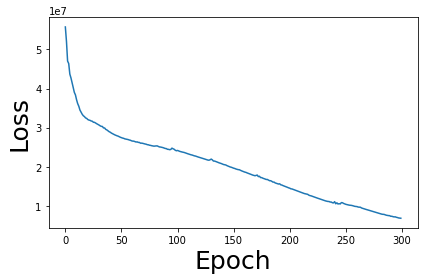

In [10]:
%%time
train_SGPR(
    model,
    optimizer=tf.keras.optimizers.Adam(lr),
    epochs=nepochs
)

print(
    f"Training error: {mean_squared_error(Y, model.predict_f(X)[0])}"
)

In [11]:
tight_priors = {
    param: tfp.distributions.Uniform(
        unscaled_data[param].min(), unscaled_data[param].max()
    )
    for param in param_names
}

density_model = BoundedDensityModel(
    likelihood=model.predict_f,
    param_names=param_names,
    priors=tight_priors,
    parameters_scaler=x_scaler,
    y_scaler=y_scaler,
)

In [12]:
latex_param_names = [
    r"$\mathcal{M}$",
    r"$\Lambda$",
]

In [13]:
#EOS MODEL PLOTS AND FUNCTION

mass = []

def getEoSInterp3(mass, eosname=None):
        '''
        This method accepts one of the NS native equations of state
        and uses that to return a list [ Λ, max_mass].
        eosname     :: Equation of state native to LALsuite
        '''

        if eosname is None:
            print('Allowed equation of state models are:')
            print(lalsim.SimNeutronStarEOSNames)
            print('Pass the model name as a string')
            return None
        try:
            assert eosname in list(lalsim.SimNeutronStarEOSNames)
        except AssertionError:
            print('EoS family is not available in lalsimulation')
            print('Allowed EoS are :\n' + str(lalsim.SimNeutronStarEOSNames))
            print('Make sure that if you are passing a custom file, it exists')
            print('in the path that you have provided...')
            sys.exit(0)

        eos = lalsim.SimNeutronStarEOSByName(eosname)
        fam = lalsim.CreateSimNeutronStarFamily(eos)
        max_mass = lalsim.SimNeutronStarMaximumMass(fam)/lal.MSUN_SI

        # This is necessary so that interpolant is computed over the full range
        # Keeping number upto 3 decimal places
        # Not rounding up, since that will lead to RuntimeError
        max_mass = int(max_mass*1000)/1000
        mass = np.linspace(1.0, max_mass, 1000)
        mass = mass[mass <= max_mass]
        Lambdas = []
        for m in mass:
            try:
                rr = lalsim.SimNeutronStarRadius(m*lal.MSUN_SI, fam)
                kk = lalsim.SimNeutronStarLoveNumberK2(m*lal.MSUN_SI, fam)
                cc = m*lal.MRSUN_SI/rr
                Lambdas = np.append(Lambdas, (2/3)*kk/(cc**5))
            except RuntimeError:
                break
        Lambdas = np.array(Lambdas)
        return Lambdas, max_mass

In [14]:
eos_SLY = lalsim.SimNeutronStarEOSByName('SLY')
fam_SLY = lalsim.CreateSimNeutronStarFamily(eos_SLY)
max_mass_SLY = lalsim.SimNeutronStarMaximumMass(fam_SLY)/lal.MSUN_SI
mass_SLY=np.linspace(1.0,max_mass_SLY,1000)

eos_ALF2 = lalsim.SimNeutronStarEOSByName('ALF2')
fam_ALF2 = lalsim.CreateSimNeutronStarFamily(eos_ALF2)
max_mass_ALF2 = lalsim.SimNeutronStarMaximumMass(fam_ALF2)/lal.MSUN_SI
mass_ALF2=np.linspace(1.0,max_mass_ALF2,1000)

eos_H4 = lalsim.SimNeutronStarEOSByName('H4')
fam_H4 = lalsim.CreateSimNeutronStarFamily(eos_H4)
max_mass_H4 = lalsim.SimNeutronStarMaximumMass(fam_H4)/lal.MSUN_SI
mass_H4=np.linspace(1.0,max_mass_H4,1000)

eos_ALF1 = lalsim.SimNeutronStarEOSByName('ALF1')
fam_ALF1 = lalsim.CreateSimNeutronStarFamily(eos_ALF1)
max_mass_ALF1 = lalsim.SimNeutronStarMaximumMass(fam_ALF1)/lal.MSUN_SI
mass_ALF1=np.linspace(1.0,max_mass_ALF1,1000)

eos_MS1 = lalsim.SimNeutronStarEOSByName('MS1')
fam_MS1 = lalsim.CreateSimNeutronStarFamily(eos_MS1)
max_mass_MS1 = lalsim.SimNeutronStarMaximumMass(fam_MS1)/lal.MSUN_SI
mass_MS1=np.linspace(1.0,max_mass_MS1,1000)

eos_APR = lalsim.SimNeutronStarEOSByName('APR')
fam_APR = lalsim.CreateSimNeutronStarFamily(eos_APR)
max_mass_APR = lalsim.SimNeutronStarMaximumMass(fam_APR)/lal.MSUN_SI
mass_APR =np.linspace(1.0,max_mass_APR,1000)

eos_WFF1 = lalsim.SimNeutronStarEOSByName('WFF1')
fam_WFF1 = lalsim.CreateSimNeutronStarFamily(eos_WFF1)
max_mass_WFF1 = lalsim.SimNeutronStarMaximumMass(fam_WFF1)/lal.MSUN_SI
mass_WFF1 =np.linspace(1.0,max_mass_WFF1,1000)

eos_MPA1 = lalsim.SimNeutronStarEOSByName('MPA1')
fam_MPA1 = lalsim.CreateSimNeutronStarFamily(eos_MPA1)
max_mass_MPA1 = lalsim.SimNeutronStarMaximumMass(fam_MPA1)/lal.MSUN_SI
mass_MPA1 =np.linspace(1.0,max_mass_MPA1,1000)

eos_ENG = lalsim.SimNeutronStarEOSByName('ENG')
fam_ENG = lalsim.CreateSimNeutronStarFamily(eos_ENG)
max_mass_ENG = lalsim.SimNeutronStarMaximumMass(fam_ENG)/lal.MSUN_SI
mass_ENG =np.linspace(1.0,max_mass_ENG,1000)

In [15]:
lambdasalf2, maxmassalf2 = getEoSInterp3(mass, eosname='ALF2')
lambdash4, maxmassh4 = getEoSInterp3(mass, eosname='H4')
lambdassly, maxmasssly = getEoSInterp3(mass, eosname='SLY')
lambdasms1, maxmassms1 = getEoSInterp3(mass, eosname='MS1')
lambdasalf1, maxmassalf1 = getEoSInterp3(mass, eosname='ALF1')
lambdasapr, maxmassapr = getEoSInterp3(mass, eosname='APR')
lambdaswff1, maxmasswff1 = getEoSInterp3(mass, eosname='WFF1')
lambdasmpa1, maxmassmpa1 = getEoSInterp3(mass, eosname='MPA1')
lambdaseng, maxmasseng = getEoSInterp3(mass, eosname='ENG')

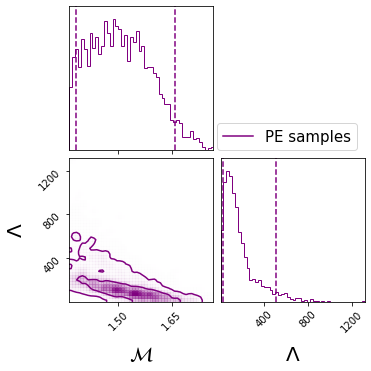

In [16]:
%matplotlib inline
import arviz as az

blue_line = matplotlib.lines.Line2D([], [], color='purple', label='PE samples')
#red_line = matplotlib.lines.Line2D([], [], color='darkorange', label='ALF2')
fig = corner.corner(
    unscaled_data[param_names],
    bins=50,
    labels=latex_param_names,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color="purple",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)


#plt.figure(fig1)

#plt.plot(mass_ALF2,lambdasalf2,color="blue",label=r"ALF2")

#plt.plot(mass_H4,lambdash4,color="red",label=r"H4")

#plt.plot(mass_SLY,lambdassly,color="green",label=r"SLY")

#plt.legend(fontsize=20)
#plt.xlabel(r"Mass $(M_\odot)$",fontsize=25)
#plt.ylabel(r"Tidal Deformability $\Lambda$",fontsize=25)

plt.legend(handles=[blue_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4, fontsize=15)

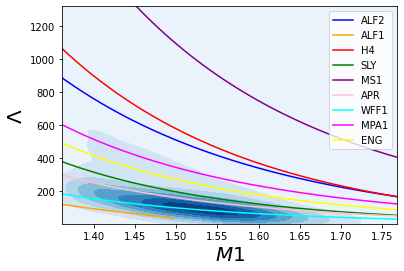

In [17]:
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st
x1 = unscaled_data['m1_source']
y1 = unscaled_data['Lambda1']
xmin, xmax = unscaled_data['m1_source'].min(), unscaled_data['m1_source'].max()
ymin, ymax = unscaled_data['Lambda1'].min(), unscaled_data['Lambda1'].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x1, y1])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
#f = np.reshape(unscaled_data[param_names](positions).T, xx.shape)
fig = pl.figure()
ax = fig.gca()
pl.plot(mass_ALF2,lambdasalf2,color="blue",label=r"ALF2")
pl.plot(mass_ALF1,lambdasalf1,color="orange",label=r"ALF1")
pl.plot(mass_H4,lambdash4,color="red",label=r"H4")
pl.plot(mass_SLY,lambdassly,color="green",label=r"SLY")
pl.plot(mass_MS1,lambdasms1,color="purple",label=r"MS1")
pl.plot(mass_APR,lambdasapr,color="pink",label=r"APR")
pl.plot(mass_WFF1,lambdaswff1,color="cyan",label=r"WFF1")
pl.plot(mass_MPA1,lambdasmpa1,color="magenta",label=r"MPA1")
pl.plot(mass_ENG,lambdaseng,color="yellow",label=r"ENG")
pl.legend(fontsize=10)
pl.xlabel(r"$M1$",fontsize=20)
pl.ylabel(r"$\Lambda$",fontsize=20)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy,f, cmap='Blues')
pl.show()



/home/sama.al-shammari/.conda/envs/nseosgp/lib/python3.7/site-packages/seaborn/distributions.py:1647: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/home/sama.al-shammari/.conda/envs/nseosgp/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/sama.al-shammari/.conda/envs/nseosgp/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


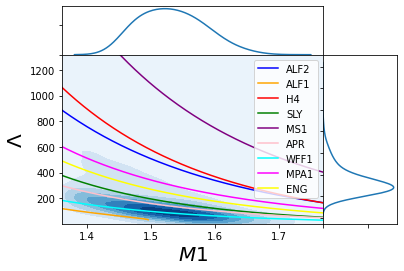

In [18]:
import seaborn as sns
fig, axes = plt.subplots(2, 2, 
                         gridspec_kw={
                             'width_ratios': [7, 2],
                             'height_ratios': [2, 7]})  
#axes[0, 0].sns '-') 
#axes[0, 1].plot(x, y2, 'm--o') 
#axes[1, 0].plot(x, y3, 'b--o') 
#axes[1, 1].plot(x, y4, 'r--o')
#fig = pl.figure()
#ax = fig.gca()
axes[1, 0].plot(mass_ALF2,lambdasalf2,color="blue",label=r"ALF2")
axes[1, 0].plot(mass_ALF1,lambdasalf1,color="orange",label=r"ALF1")
axes[1, 0].plot(mass_H4,lambdash4,color="red",label=r"H4")
axes[1, 0].plot(mass_SLY,lambdassly,color="green",label=r"SLY")
axes[1, 0].plot(mass_MS1,lambdasms1,color="purple",label=r"MS1")
axes[1, 0].plot(mass_APR,lambdasapr,color="pink",label=r"APR")
axes[1, 0].plot(mass_WFF1,lambdaswff1,color="cyan",label=r"WFF1")
axes[1, 0].plot(mass_MPA1,lambdasmpa1,color="magenta",label=r"MPA1")
axes[1, 0].plot(mass_ENG,lambdaseng,color="yellow",label=r"ENG")
axes[1, 0].legend(fontsize=10)
axes[1, 0].set_xlabel(r"$M1}$",fontsize=20)
axes[1, 0].set_ylabel(r"$\Lambda$",fontsize=20)
axes[1, 0].set_xlim(xmin, xmax)
axes[1, 0].set_ylim(ymin, ymax)
# Contourf plot
cfset = axes[1, 0].contourf(xx, yy,f, cmap='Blues')

L1 = unscaled_data['Lambda1']
M1= unscaled_data['m1_source']
sns.set_style('white')
right = sns.kdeplot(np.array(L1), ax=axes[1, 1], bw=0.5,vertical=True)
right.set(xticklabels=[])
right.set(xlabel=None)
right.set(yticklabels=[])
right.set(ylabel=None)

up = sns.kdeplot(np.array(M1), ax=axes[0, 0], bw=0.5)
up.set(xticklabels=[])
up.set(xlabel=None)
up.set(yticklabels=[])
up.set(ylabel=None)

fig.delaxes(axes[0,1])
pl.subplots_adjust(wspace=0, hspace=0)
pl.savefig("./PE_EOS.png", dpi=100)
pl.show()

In [19]:
#from plotly.figure_factory import create_2d_density
#colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)',
 #            (1, 1, 0.2), (0.98,0.98,0.98)]
#fig = create_2d_density(x, y, colorscale=colorscale,
#      hist_color='rgb(255, 237, 222)', point_size=3)
#fig.show()
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl

#Y = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
#data = sns.load_dataset()
#data = np.vstack([unscaled_data['m1_source'],unscaled_data['Lambda1']])
#ax = sns.jointplot(data=data,kind='kde')
#ax.patch.set_facecolor('white')
#ax.collections[0].set_alpha(0)
#ax.set_xlabel('$Y_1$', fontsize = 15)
#ax.set_ylabel('$Y_0$', fontsize = 15)
#pl.xlim(-3, 3)
#pl.ylim(-3, 3)
#pl.plot([-3, 3], [-3, 3], color = "black", linewidth = 1)
#pl.show()

/home/sama.al-shammari/.conda/envs/nseosgp/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

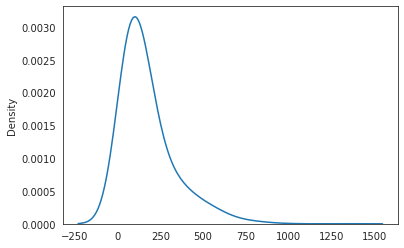

In [20]:
import numpy as np
import seaborn as sns
data = unscaled_data['Lambda1']
sns.set_style('white')
sns.kdeplot(np.array(data), bw=0.5)

Text(0, 0.5, 'Tidal Deformability $\\Lambda$')

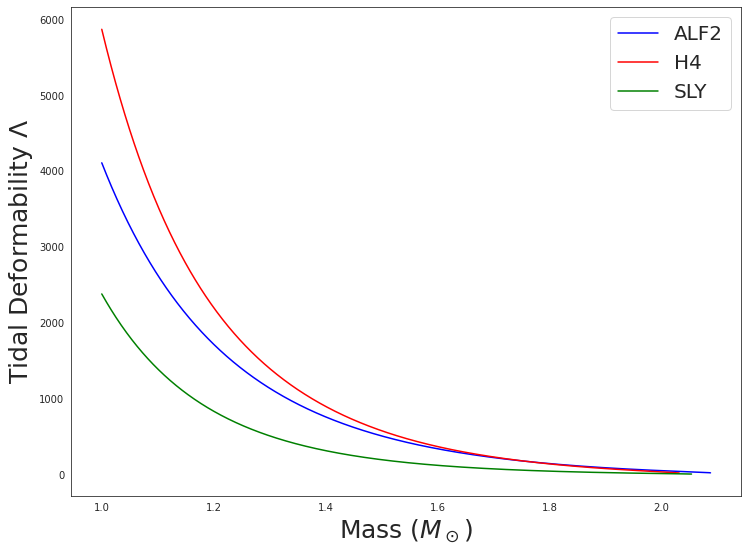

In [21]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 9))

plt.plot(mass_ALF2,lambdasalf2,color="blue",label=r"ALF2")

plt.plot(mass_H4,lambdash4,color="red",label=r"H4")

plt.plot(mass_SLY,lambdassly,color="green",label=r"SLY")

plt.legend(fontsize=20)
plt.xlabel(r"Mass $(M_\odot)$",fontsize=25)
plt.ylabel(r"Tidal Deformability $\Lambda$",fontsize=25)

In [22]:
from scipy import interpolate
from scipy.interpolate import interp1d

def integrator(Nb,m,l,x_scaler,y_scaler):
    '''
    This function numerically integrates along the
    EoS curve.
    '''
    # perform integration via trapazoidal approximation
    #x_new_scaled = x_scaler.transform(x_space.reshape(-1, 1))
    #x_new_scaled = np.vstack((mass,lambdas).T)
    #x_new_scaled = x_scaler.transform(create_2d_data_set(bin_array))
    Nb = Nb*6
    new_bin_array = np.vstack(
        [
            np.linspace(
                m.min() - 0.1, m.max() + 0.1, Nb
            ),
            np.linspace(
                l.min() - 0.1, l.max() + 0.1, Nb
            ),
        ]
    )
    bin_grid = x_scaler.transform(create_2d_data_set(new_bin_array))
    dm = np.diff(m)
    #stacked = np.vstack([m,l])
    #stacked_scaled = x_scaler.transform(stacked.T)
    f , kappa= density_model.predict(bin_grid)
    #bin_shape = Nb - 1
    z = y_scaler.inverse_transform(f)
    #z = z.reshape(bin_shape, bin_shape, order="C")
    #z = z / z.sum()
    #n = 1000
    #t = np.linspace(0, z.max(), n)
    
    #f, kappa= density_model.predict(stacked_scaled) #given trained model, predict the y-value(density for e.g) of a new set of data.
    #This method accepts one argument, the new data (X_new_scaled),
    #and returns the learned label for each object in the array.
    f_centers = 0.5*(z[1:] + z[:-1])
    int_element = f_centers * dm.T
    
    #integral = ((z >= t[:, None, None]) * z).sum(axis=(1, 2))
    #f_interp = interpolate.interp1d(integral, t)
    #int_element = f_interp * dm.T
    return np.sum(int_element), f, kappa

In [23]:
evidence_sum, mean, var = integrator(36,mass_WFF1,lambdaswff1,x_scaler,y_scaler)
print(evidence_sum)

Shape of binning: (215, 2)
Histogram points: (46225, 2)
36.15005731056941


In [24]:
Nb = 500
new_bin_array = np.vstack(
    [
         np.linspace(
             1.4 - 0.1, 1.7 + 0.1, Nb
        ),
        np.linspace(
            0 - 0.1, 1200 + 0.1, Nb
        ),
    ]
)
bin_grid = x_scaler.transform(create_2d_data_set(new_bin_array))
dm = np.diff(mass_ALF1)
f , kappa= density_model.predict(bin_grid)
bin_shape = Nb - 1
z = y_scaler.inverse_transform(f)
z = z.reshape(bin_shape, bin_shape, order="C")
z = z / z.sum()
n = 1000
t = np.linspace(0, z.max(), n)

Shape of binning: (499, 2)
Histogram points: (249001, 2)


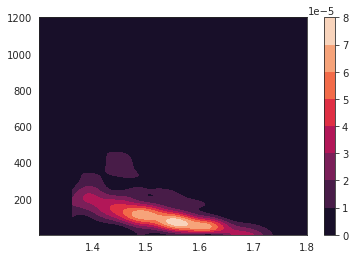

In [25]:
plt.contourf(new_bin_array[0,1:],new_bin_array[1,1:], z.T)
plt.colorbar()
#lengthscale too short so falls back to GP prior
#overfitting

Checking using KDEs

In [26]:
from scipy import stats

In [27]:
x1 = unscaled_data['m1_source']
y1 = unscaled_data['Lambda1']
xmin, xmax = unscaled_data['m1_source'].min(), unscaled_data['m1_source'].max()
ymin, ymax = unscaled_data['Lambda1'].min(), unscaled_data['Lambda1'].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x1, y1])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

#dens_std, dens_std_unscaled = calc_hist_errors(np.array(unscaled_data[param_names]), bin_array, y_scaler)
#dens_std_1 = dens_std 
#var = dens_std_1 ** 2 +  1 * 10 ** - 6
#len(var)

In [28]:
def integrator_kde(m,l,postfunc,
               var_Lambda1=1.0, var_m1=1.0):
    '''
    This function numerically integrates the KDE along the
    EoS curve.
    '''
    # scale things back so they make sense with the KDE
    Lambda1_scaled, m1_scaled = l/var_Lambda1, m/var_m1

    # perform integration via trapazoidal approximation
    dm = np.diff(m)
    f = postfunc.evaluate(np.vstack((Lambda1_scaled, m1_scaled)))#.T)
    f_centers = 0.5*(f[1:] + f[:-1])
    int_element = f_centers * dm

    return np.sum(int_element)

In [29]:
integrator_kde(mass_WFF1,lambdaswff1,kernel,var_Lambda1=1.0, var_m1=1.0)

5.740378779419429e-73

Uncertainties

In [30]:
def uncertainties(Nb,sigmas,m,l,x_scaler,y_scaler):
    Nb = Nb
    new_bin_array = np.vstack(
        [
            np.linspace(
                m.min() - 0.1, m.max() + 0.1, Nb
            ),
            np.linspace(
                l.min() - 0.1, l.max() + 0.1, Nb
            ),
        ]
    )
    bin_grid = x_scaler.transform(create_2d_data_set(new_bin_array))
    mean , var = density_model.predict(bin_grid)
    bin_shape = Nb - 1
    z = y_scaler.inverse_transform(mean)
    
    z_high = y_scaler.inverse_transform(mean + sigmas*np.sqrt(var))
    z_high = z_high.reshape(bin_shape, bin_shape)
    z_high = z_high / z.sum()

    z_low = y_scaler.inverse_transform(mean - sigmas*np.sqrt(var)).clip(min=0.)
    z_low = z_low.reshape(bin_shape, bin_shape, order="C")
    z_low = z_low / z.sum()
    
    z = z.reshape(bin_shape, bin_shape, order="C")
    z = z / z.sum()
    n = 1000
    t = np.linspace(0, z.max(), n)    
    integral = ((z >= t[:, None, None]) * z).sum(axis=(1, 2))
    f_interp = interpolate.interp1d(integral, t)
    t_contours = f_interp(np.array([0.9, 0.5]))
    mean = mean.reshape(bin_shape, bin_shape, order="C")
    gp_var = var.reshape(bin_shape, bin_shape, order="C")
    
    mean_m1 = np.mean(mean, axis=1)
    mean_L1 = np.mean(mean, axis=0)

    std_m1 = np.sqrt(np.mean(gp_var, axis=1))
    std_L1 = np.sqrt(np.mean(gp_var, axis=1))

    sum_with_error_m1 = unumpy.uarray(mean_m1, std_m1)
    sum_with_error_L1 = unumpy.uarray(mean_L1, std_L1)

    scaled_sum_with_error_m1 = sum_with_error_m1 * y_scaler.scale_
    scaled_sum_with_error_m1 = scaled_sum_with_error_m1 + y_scaler.mean_

    scaled_sum_with_error_L1 = sum_with_error_L1 * y_scaler.scale_
    scaled_sum_with_error_L1 = scaled_sum_with_error_L1 + y_scaler.mean_
    
    # Normalise so that it is a density
    scaled_dens_with_error_m1 = (
    scaled_sum_with_error_m1
    * 1
    / (unumpy.nominal_values(scaled_sum_with_error_m1) * np.diff(new_bin_array[0])).sum()
    )
    
    scaled_dens_with_error_L1 = (
    scaled_sum_with_error_L1
    * 1
    / (unumpy.nominal_values(scaled_sum_with_error_L1) * np.diff(new_bin_array[1])).sum()
    )
    
    # Extracting error with uncertainty package
    scaled_m1_std = unumpy.std_devs(scaled_dens_with_error_m1)
    scaled_L1_std = unumpy.std_devs(scaled_dens_with_error_L1)
    
    scaled_m1_mean = unumpy.nominal_values(scaled_dens_with_error_m1)
    scaled_L1_mean = unumpy.nominal_values(scaled_dens_with_error_L1)
    
    # Estimating the 2-sigma confidence bands
    upper_var_m1 = scaled_m1_mean + sigmas * scaled_m1_std
    lower_var_m1 = scaled_m1_mean - sigmas * scaled_m1_std
    
    upper_var_L1 = scaled_L1_mean + sigmas * scaled_L1_std
    lower_var_L1 = scaled_L1_mean - sigmas * scaled_L1_std
    
    return scaled_m1_mean, scaled_L1_mean, upper_var_m1, lower_var_m1, upper_var_L1, lower_var_L1, t_contours, z_low, z_high
    

In [31]:
scaled_m1_mean, scaled_L1_mean, upper_var_m1, lower_var_m1, upper_var_L1, lower_var_L1, t_contours, z_low, z_high = uncertainties(36,2,mass_WFF1,lambdaswff1,x_scaler,y_scaler) 

Shape of binning: (35, 2)
Histogram points: (1225, 2)


In [43]:
print(scaled_m1_mean)

[-2.33495485e-16 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16
 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16
 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16
  2.94648759e+00  3.48562110e+00  3.81571784e+00  4.06303516e+00
  3.69447485e+00  3.33062958e+00  2.44213328e+00  1.23006514e+00
  7.43455734e-01  3.08709884e-01  1.13588599e-01 -2.33495485e-16
 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16
 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16
 -2.33495485e-16 -2.33495485e-16 -2.33495485e-16]


In [40]:
m = mass_WFF1
l = lambdaswff1
new_bin_array = np.vstack(
    [
        np.linspace(
            m.min() - 0.1, m.max() + 0.1, Nb
        ),
        np.linspace(
            l.min() - 0.1, l.max() + 0.1, Nb
        ),
    ]
)
bin_plot = new_bin_array.copy()

counts, bins = np.histogramdd(
    np.array(unscaled_data[param_names]), density=True, bins=new_bin_array
)

#counts, bins = np.histogramdd(
#    np.array((m,l)).T, density=True, bins=new_bin_array
#)

#summary_m1 = calc_mean_and_ci(unscaled_data["m1_source"])
#summary_L1 = calc_mean_and_ci(unscaled_data["Lambda1"])
    
summary_m1 = calc_mean_and_ci(unscaled_data["m1_source"])
summary_L1 = calc_mean_and_ci(unscaled_data["Lambda1"])    
print(r"PE m1 = {}".format(summary_m1.string))
print(r"PE L1 = {}".format(summary_L1.string))

PE m1 = ${1.50}_{-0.09}^{+0.10}$
PE L1 = ${125.19}_{-76.15}^{+181.93}$


In [41]:
from scipy.interpolate import interp1d

In [42]:
f_L1 = interp1d(np.cumsum(scaled_L1_mean,)/np.cumsum(scaled_L1_mean,)[-1],centroid_calc(bins[1]))
f_m1 = interp1d(np.cumsum(scaled_m1_mean,)/np.cumsum(scaled_m1_mean,)[-1],centroid_calc(bins[0]))

ValueError: x and y arrays must be equal in length along interpolation axis.

/home/sama.al-shammari/.conda/envs/nseosgp/lib/python3.7/site-packages/ipykernel_launcher.py:208: UserWarning: No contour levels were found within the data range.


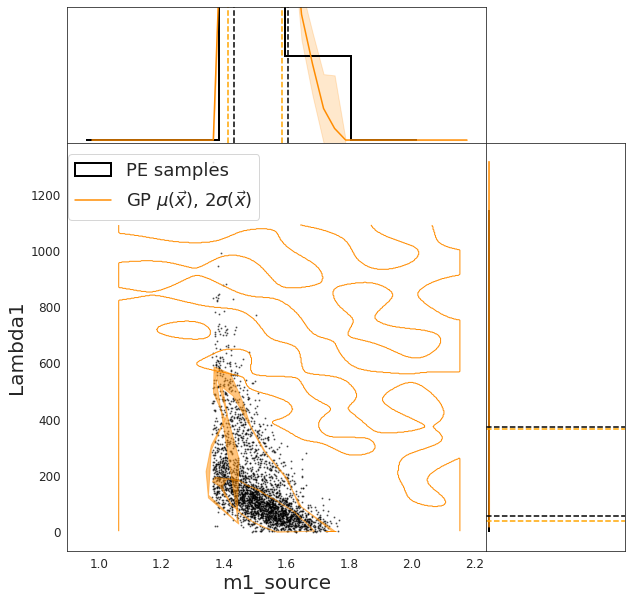

In [39]:
%matplotlib inline
fig, axes = plt.subplots(
    figsize=(10, 10),
    sharex=False,
    sharey=False,
    ncols=2,
    nrows=2,
    gridspec_kw={"width_ratios": [3, 1], "height_ratios": [1, 3]},
)

plot_1d_histograms_with_GP(axes,
                           unscaled_data,
                           bins,
                           scaled_m1_mean,
                           scaled_L1_mean,
                           lower_var_m1,
                           upper_var_m1,
                           lower_var_L1,
                           upper_var_L1)
plot_1d_credible_intervals(axes, f_m1, f_L1, summary_m1, summary_L1)

lower_contours, upper_contours = get_contour_bounds(axes, t_contours, z_low, z_high)
xx_lower, xx_upper, yy_lower, yy_upper, interp_lower_x, interp_lower_y, interp_upper_x, interp_upper_y = get_fill_positions(lower_contours, upper_contours)
make_central_fill_plot(xx_lower,
                       xx_upper,
                       yy_lower,
                       yy_upper,
                       interp_lower_x,
                       interp_lower_y,
                       interp_upper_x,
                       interp_upper_y)


#plot_arrows(axes)

do_plot_formatting()

add_legend_to_plot(axes)